Train columns: Index(['datetime', 'week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek',
       'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc', 'DEMAND'],
      dtype='object')
Test columns: Index(['datetime', 'week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek',
       'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc', 'DEMAND'],
      dtype='object')


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
SARIMAX MSE: 26761206.469627205
SARIMAX Error as Percentage of Actual Mean: 410.06%
XGBoost MSE: 3893.3012481315977
XGBoost Error as Percentage of Actual Mean: 4.95%
Random Forest MSE: 3423.435826651121
Random Forest Error as Percentage of Actual Mean: 4.64%
LSTM MSE: 1751.0128043799025
LSTM Error as Percentage of Actual Mean: 3.32%
Ensemble Model MSE: 22953.000791551385
Ensemble Error as Percentage of Actual Mean: 11.91%
Model Contributions to Ensemble: SARIMAX: 0.00%, XGBoost: 22.93%, Random Forest: 26.08%, LSTM: 50.99%


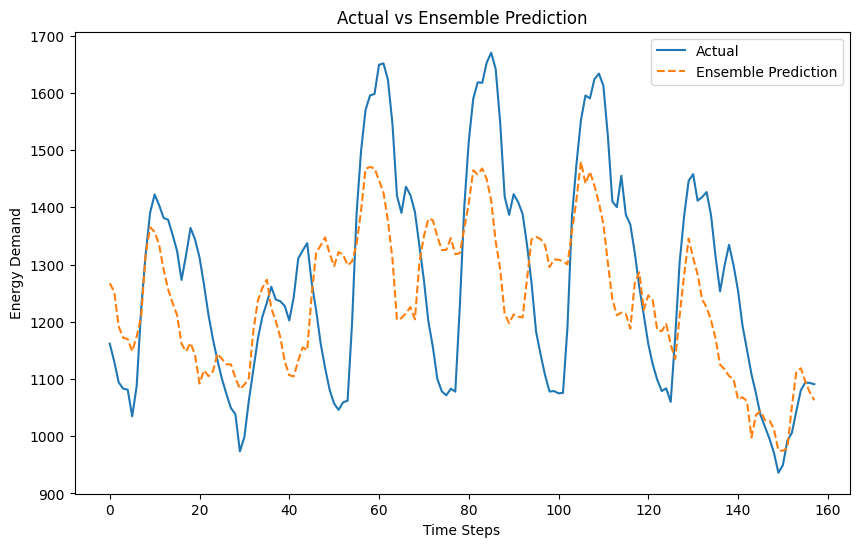

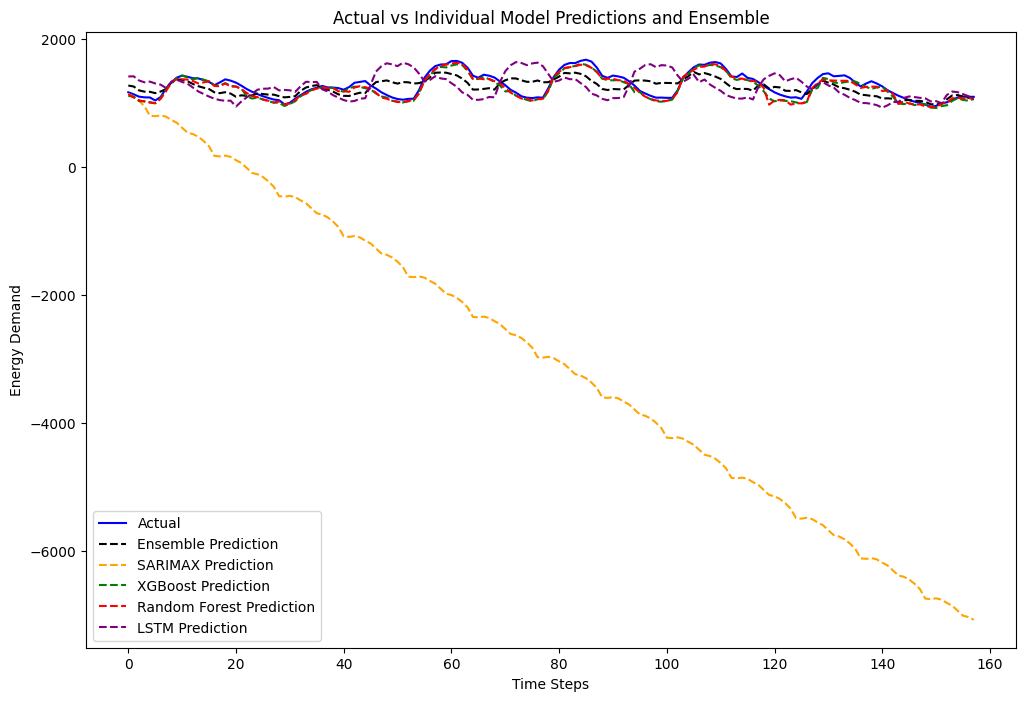

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
train_data_path = 'energy/train_dataframes.xlsx'
test_data_path = 'energy/test_dataframes.xlsx'
continuous_data_path = 'energy/continuous dataset.csv'
weekly_forecast_path = 'energy/weekly pre-dispatch forecast.csv'

# Load data
train = pd.read_excel(train_data_path, sheet_name=0)
test = pd.read_excel(test_data_path, sheet_name=0)

# Inspect column names
print(f'Train columns: {train.columns}')
print(f'Test columns: {test.columns}')

# Convert 'datetime' column to datetime if present
if 'datetime' in train.columns:
    train['datetime'] = pd.to_datetime(train['datetime'], errors='coerce')
if 'datetime' in test.columns:
    test['datetime'] = pd.to_datetime(test['datetime'], errors='coerce')

# Ensure data is sorted by datetime
train.sort_values(by=['datetime'], inplace=True)

# Example: Assuming 'DEMAND' is the target column
target = 'DEMAND'

# Prepare features and target
X = train.drop(columns=['datetime', target])
y = train[target]

# Fill missing values if any
X = X.ffill()

# Split training and test datasets explicitly
train_X, train_y = X, y
test_X = test.drop(columns=['datetime', target])
test_y = test[target]

# Fill missing values in test data
test_X = test_X.ffill()

# Step 2: Train models

# 2.1 SARIMAX (Only if sufficient data is available)
if len(train_y) > 24:  # Threshold to ensure enough data points
    sarimax_model = SARIMAX(train_y, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12)).fit()
    sarimax_pred = sarimax_model.forecast(steps=len(test_y))
    sarimax_mse = mean_squared_error(test_y, sarimax_pred)
else:
    sarimax_pred = np.zeros(len(test_y))  # Placeholder prediction for small datasets
    sarimax_mse = float('inf')

# 2.2 XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(train_X, train_y)
xgb_pred = xgb_model.predict(test_X)
xgb_mse = mean_squared_error(test_y, xgb_pred)

# 2.3 Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)
rf_mse = mean_squared_error(test_y, rf_pred)

# 2.4 LSTM
# Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
if len(train_y) > seq_length:
    train_seq, train_labels = create_sequences(train_y.values, seq_length)
    test_seq, test_labels = create_sequences(test_y.values, seq_length)

    # Reshape for LSTM (samples, timesteps, features)
    train_seq = train_seq.reshape((train_seq.shape[0], train_seq.shape[1], 1))
    test_seq = test_seq.reshape((test_seq.shape[0], test_seq.shape[1], 1))

    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(train_seq, train_labels, epochs=20, batch_size=32, verbose=0)
    lstm_pred = lstm_model.predict(test_seq).flatten()
    lstm_mse = mean_squared_error(test_labels, lstm_pred)
else:
    lstm_pred = np.zeros(len(test_y))  # Placeholder prediction for small datasets
    lstm_mse = float('inf')

# Print individual MSEs
print(f'SARIMAX MSE: {sarimax_mse}')
print(f'SARIMAX Error as Percentage of Actual Mean: {(np.sqrt(sarimax_mse) / np.mean(test_y)) * 100:.2f}%')
print(f'XGBoost MSE: {xgb_mse}')
print(f'XGBoost Error as Percentage of Actual Mean: {(np.sqrt(xgb_mse) / np.mean(test_y)) * 100:.2f}%')
print(f'Random Forest MSE: {rf_mse}')
print(f'Random Forest Error as Percentage of Actual Mean: {(np.sqrt(rf_mse) / np.mean(test_y)) * 100:.2f}%')
print(f'LSTM MSE: {lstm_mse}')
print(f'LSTM Error as Percentage of Actual Mean: {(np.sqrt(lstm_mse) / np.mean(test_y)) * 100:.2f}%')

# Step 3: Calculate weights based on MSE (1/mse)
sarimax_weight = 1 / sarimax_mse if sarimax_mse != float('inf') else 0
xgb_weight = 1 / xgb_mse if xgb_mse != float('inf') else 0
rf_weight = 1 / rf_mse if rf_mse != float('inf') else 0
lstm_weight = 1 / lstm_mse if lstm_mse != float('inf') else 0

total_weight = sarimax_weight + xgb_weight + rf_weight + lstm_weight
weights = [sarimax_weight / total_weight, xgb_weight / total_weight, rf_weight / total_weight, lstm_weight / total_weight]  # Equal weights for now
min_length = min(len(sarimax_pred), len(xgb_pred), len(rf_pred), len(lstm_pred))
ensemble_pred = (weights[0] * sarimax_pred[:min_length] +
                 weights[1] * xgb_pred[:min_length] +
                 weights[2] * rf_pred[:min_length] +
                 weights[3] * lstm_pred[:min_length])

# Step 4: Evaluate the ensemble model
mse = mean_squared_error(test_y[:min_length], ensemble_pred)
print(f'Ensemble Model MSE: {mse}')
print(f'Ensemble Error as Percentage of Actual Mean: {(np.sqrt(mse) / np.mean(test_y[:min_length])) * 100:.2f}%')

# Print percentage contribution of each model to the ensemble
sarimax_pct = (weights[0] * 100)
xgb_pct = (weights[1] * 100)
rf_pct = (weights[2] * 100)
lstm_pct = (weights[3] * 100)
print(f'Model Contributions to Ensemble: SARIMAX: {sarimax_pct:.2f}%, XGBoost: {xgb_pct:.2f}%, Random Forest: {rf_pct:.2f}%, LSTM: {lstm_pct:.2f}%')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_y[:min_length])), test_y[:min_length], label='Actual')
plt.plot(range(len(ensemble_pred)), ensemble_pred, label='Ensemble Prediction', linestyle='--')
plt.legend()
plt.title('Actual vs Ensemble Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Energy Demand')
plt.savefig('ensemble_vs_actual_energy.png')
plt.show()

# Plot individual model predictions vs actual and ensemble (aligned properly)
plt.figure(figsize=(12, 8))
x_axis = range(len(test_y[:min_length]))
plt.plot(x_axis, test_y[:min_length], label='Actual', color='blue')
plt.plot(x_axis, ensemble_pred, label='Ensemble Prediction', linestyle='--', color='black')
plt.plot(x_axis, sarimax_pred[:min_length], label='SARIMAX Prediction', linestyle='--', color='orange')
plt.plot(x_axis, xgb_pred[:min_length], label='XGBoost Prediction', linestyle='--', color='green')
plt.plot(x_axis, rf_pred[:min_length], label='Random Forest Prediction', linestyle='--', color='red')
plt.plot(x_axis, lstm_pred[:min_length], label='LSTM Prediction', linestyle='--', color='purple')
plt.legend()
plt.title('Actual vs Individual Model Predictions and Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Energy Demand')
plt.savefig('individual_vs_actual_energy.png')
plt.show()


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
SARIMAX MSE: 25537104.77421899
XGBoost MSE: 1117.5499872967782
Random Forest MSE: 2459.888407534159
LSTM MSE: 67835.51820107237
Final SARIMAX MSE: 22732949.849502657
Final SARIMAX Error as Percentage of Actual Mean: 373.73%
Final XGBoost MSE: 1140.7780124720487
Final XGBoost Error as Percentage of Actual Mean: 2.65%
Final Random Forest MSE: 2345.0335827658105
Final Random Forest Error as Percentage of Actual Mean: 3.80%
Final LSTM MSE: 138504.07138912048
Final LSTM Error as Percentage of Actual Mean: 29.17%
Final Ensemble MSE: 1471.4523301329357
Final Ensemble Error as Percentage of Actual Mean: 3.01%


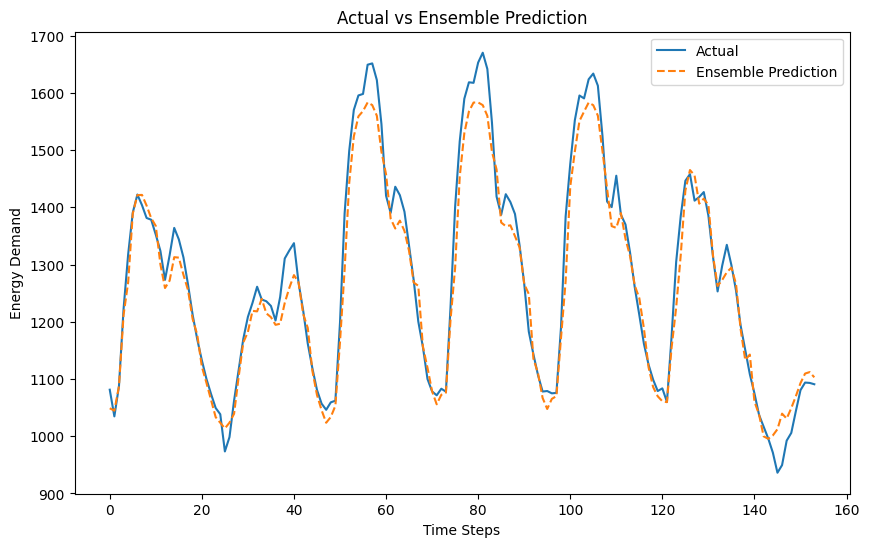

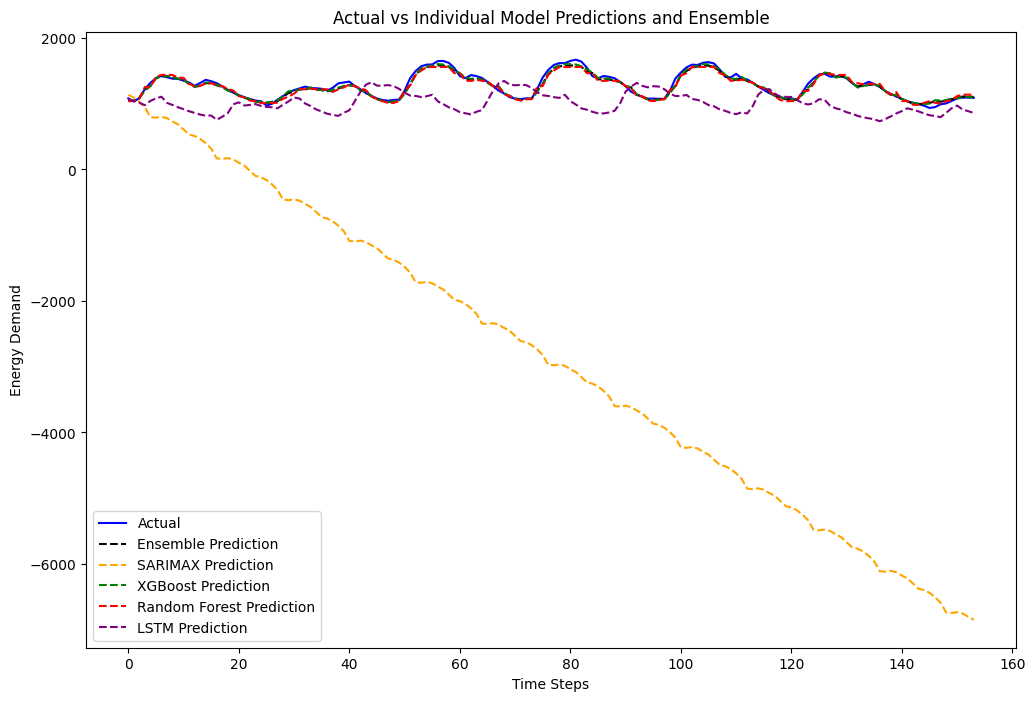

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
train_data_path = 'energy/train_dataframes.xlsx'
test_data_path = 'energy/test_dataframes.xlsx'

# Load data
train = pd.read_excel(train_data_path, sheet_name=0)
test = pd.read_excel(test_data_path, sheet_name=0)

# Convert 'datetime' column to datetime if present
if 'datetime' in train.columns:
    train['datetime'] = pd.to_datetime(train['datetime'], errors='coerce')
if 'datetime' in test.columns:
    test['datetime'] = pd.to_datetime(test['datetime'], errors='coerce')

# Ensure data is sorted by datetime
train.sort_values(by=['datetime'], inplace=True)

# Target column
target = 'DEMAND'

# Feature Engineering
# Add lag features and moving averages
for lag in [1, 2, 3, 4]:
    train[f'DEMAND_Lag_{lag}'] = train[target].shift(lag)
train['DEMAND_MA_4'] = train[target].rolling(window=4).mean()

# Handle NaN values in training data
train.ffill(inplace=True)
train.dropna(inplace=True)

# Prepare features and target
X = train.drop(columns=['datetime', target])
y = train[target]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
train_X = pd.DataFrame(scaled_features, columns=X.columns)
train_y = y

# Handle test dataset
for lag in [1, 2, 3, 4]:
    test[f'DEMAND_Lag_{lag}'] = test[target].shift(lag)
test['DEMAND_MA_4'] = test[target].rolling(window=4).mean()

# Handle NaN values in the test set
test.ffill(inplace=True)
test.dropna(inplace=True)

# Prepare test data
X_test = test.drop(columns=['datetime', target])
scaled_test_features = scaler.transform(X_test)
test_X = pd.DataFrame(scaled_test_features, columns=X_test.columns)
test_y = test[target]

# Ensure proper datetime index for SARIMAX
train_y.index = train['datetime']
test_y.index = test['datetime']

# Step 2: Train models

# 2.1 SARIMAX
if len(train_y) > 24:
    sarimax_model = SARIMAX(train_y, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12)).fit()
    sarimax_pred = sarimax_model.get_forecast(steps=len(test_y)).predicted_mean
    sarimax_pred.index = test_y.index  # Align indices
    sarimax_mse = mean_squared_error(test_y, sarimax_pred)
else:
    sarimax_pred = np.zeros(len(test_y))  # Placeholder prediction for small datasets
    sarimax_mse = float('inf')

# 2.2 XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, enable_categorical=True)
xgb_model.fit(train_X, train_y)
xgb_pred = xgb_model.predict(test_X)
xgb_mse = mean_squared_error(test_y, xgb_pred)

# 2.3 Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5)
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)
rf_mse = mean_squared_error(test_y, rf_pred)

# 2.4 LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
if len(train_y) > seq_length:
    train_seq, train_labels = create_sequences(train_y.values, seq_length)
    test_seq, test_labels = create_sequences(test_y.values, seq_length)

    # Reshape for LSTM (samples, timesteps, features)
    train_seq = train_seq.reshape((train_seq.shape[0], train_seq.shape[1], 1))
    test_seq = test_seq.reshape((test_seq.shape[0], test_seq.shape[1], 1))

    lstm_model = Sequential([
        Input(shape=(seq_length, 1)),
        LSTM(50, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(train_seq, train_labels, epochs=20, batch_size=32, verbose=0)
    lstm_pred = lstm_model.predict(test_seq).flatten()
    lstm_mse = mean_squared_error(test_labels, lstm_pred)
else:
    lstm_pred = np.zeros(len(test_y))
    lstm_mse = float('inf')

# Print individual MSEs
print(f'SARIMAX MSE: {sarimax_mse}')
print(f'XGBoost MSE: {xgb_mse}')
print(f'Random Forest MSE: {rf_mse}')
print(f'LSTM MSE: {lstm_mse}')

# Step 3: Calculate weights based on MSE (1/mse)
sarimax_weight = 1 / sarimax_mse if sarimax_mse != float('inf') else 0
xgb_weight = 1 / xgb_mse if xgb_mse != float('inf') else 0
rf_weight = 1 / rf_mse if rf_mse != float('inf') else 0
lstm_weight = 1 / lstm_mse if lstm_mse != float('inf') else 0

total_weight = sarimax_weight + xgb_weight + rf_weight + lstm_weight
weights = [sarimax_weight / total_weight, xgb_weight / total_weight, rf_weight / total_weight, lstm_weight / total_weight]

# Ensemble predictions
min_length = min(len(sarimax_pred), len(xgb_pred), len(rf_pred), len(lstm_pred))
sarimax_pred = sarimax_pred[:min_length]
xgb_pred = xgb_pred[:min_length]
rf_pred = rf_pred[:min_length]
lstm_pred = lstm_pred[:min_length]
test_y = test_y[:min_length]
ensemble_pred = (weights[0] * sarimax_pred +
                 weights[1] * xgb_pred +
                 weights[2] * rf_pred +
                 weights[3] * lstm_pred)

# Print final MSE for each method
sarimax_final_mse = mean_squared_error(test_y, sarimax_pred)
xgb_final_mse = mean_squared_error(test_y, xgb_pred)
rf_final_mse = mean_squared_error(test_y, rf_pred)
lstm_final_mse = mean_squared_error(test_y, lstm_pred)
ensemble_final_mse = mean_squared_error(test_y, ensemble_pred)
print(f'Final SARIMAX MSE: {sarimax_final_mse}')
print(f'Final SARIMAX Error as Percentage of Actual Mean: {(np.sqrt(sarimax_final_mse) / np.mean(test_y)) * 100:.2f}%')
print(f'Final XGBoost MSE: {xgb_final_mse}')
print(f'Final XGBoost Error as Percentage of Actual Mean: {(np.sqrt(xgb_final_mse) / np.mean(test_y)) * 100:.2f}%')
print(f'Final Random Forest MSE: {rf_final_mse}')
print(f'Final Random Forest Error as Percentage of Actual Mean: {(np.sqrt(rf_final_mse) / np.mean(test_y)) * 100:.2f}%')
print(f'Final LSTM MSE: {lstm_final_mse}')
print(f'Final LSTM Error as Percentage of Actual Mean: {(np.sqrt(lstm_final_mse) / np.mean(test_y)) * 100:.2f}%')
print(f'Final Ensemble MSE: {ensemble_final_mse}')
print(f'Final Ensemble Error as Percentage of Actual Mean: {(np.sqrt(ensemble_final_mse) / np.mean(test_y)) * 100:.2f}%')

# Plot actual vs ensemble predicted
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_y)), test_y, label='Actual')
plt.plot(range(len(ensemble_pred)), ensemble_pred, label='Ensemble Prediction', linestyle='--')
plt.legend()
plt.title('Actual vs Ensemble Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Energy Demand')
plt.savefig('ensemble_vs_actual_energy.png')
plt.show()

# Plot individual model predictions vs actual and ensemble
plt.figure(figsize=(12, 8))
x_axis = range(len(test_y))
plt.plot(x_axis, test_y, label='Actual', color='blue')
plt.plot(x_axis, ensemble_pred, label='Ensemble Prediction', linestyle='--', color='black')
plt.plot(x_axis, sarimax_pred, label='SARIMAX Prediction', linestyle='--', color='orange')
plt.plot(x_axis, xgb_pred, label='XGBoost Prediction', linestyle='--', color='green')
plt.plot(x_axis, rf_pred, label='Random Forest Prediction', linestyle='--', color='red')
plt.plot(x_axis, lstm_pred, label='LSTM Prediction', linestyle='--', color='purple')
plt.legend()
plt.title('Actual vs Individual Model Predictions and Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Energy Demand')
plt.savefig('individual_vs_actual_energy.png')
plt.show()
